# Using APIs to Gather Data
### by [Jason DeBacker](http://jasondebacker.com), October 2017

This notebook provides a tutorial and examples showing how to use APIs and Python in order to gather data relevant for economic research.

## What is an API?

API stands for "Application Programming Interface".  APIs provide a way for one piece of software to interact with another by sharing data.  As such, APIs are very general and have many uses.  For example, APIs are used when you copy something from your internet browser and paste it into your word processor.  Here, we are going to focus on a relatively narrow application of APIs.  Specifically, we'll focus on using APIs to help use compile data that we can use for research.

## Why use an API?

A relevant question is why one would want to use an API rather than downloading a static datafile.  There are a few reasons for using APIs over static data:
1. Static datasets may not be available for the particular data source you are interesting in.
2. Static datasets may be too large to want to deal with - and your research involves just a selection of these data.
3. The data is changing quickly.

The last may be less relevant to academic research given our timelines, but the first two are certainly applicable.

## The JSON file format

Before we get started using APIs, lets discuss the [JSON (JavaScript Object Notation)](http://www.json.org) file format. JSON has become a standard data foramt and many APIs pass data as JSON files.  The JSON format is human-readable, but also easy for machines to parse and generate.  JSON is based on key-value pairs (like a Python dictionary) and ordered lists.  Here's an example of what JSON data look like:

```
{
     "firstName": "John",
     "lastName": "Smith",
     "address": {
         "streetAddress": "21 2nd Street",
         "city": "New York",
         "state": "NY",
         "postalCode": 10021
     },
     "phoneNumbers": [
         "212 555-1234",
         "646 555-4567"
     ]
 }
```

You can see some similarities between the what JSON is written and the way one writes data to a Python dictioinary.  They contain similar structures.  Another thing to notice about the JSON format - you can clearly understand the data that are being represented here and what they mean.

## Example 1: Using `pandas-datareader`

One of the easiest ways to use an API is Python is to use the `pandas-datareader` package.  Fortunately for our purposes, this package also provides us the ability to connect to APIs for a number of datasources that are commonly used in economics such as:

* Quandl
* St.Louis FED (FRED)
* Kenneth French’s data library
* World Bank
* OECD
* Yahoo! Finance
* Google Finance
* Eurostat
* Enigma

For the example that follows, we will gather some data from FRED and plot it.  `pandas-datareader` provides a wrapper for the [FRED API](https://research.stlouisfed.org/docs/api/fred/).


In [1]:
# import pandas-datareader and other packages
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline  

# set beginning and end dates for data
start = datetime.datetime(1947, 1, 1) # format is year (1947), month (1), day (1)
end = datetime.date.today() # go through today

# pull series of interest using pandas_datareader
fred_data=web.DataReader(["USREC", "GDPC1", "GPDIC96"], "fred", start, end)
fred_data.head(n=10)

,USREC,GDPC1,GPDIC96
DATE,,,
1947-01-01,0,1934.5,222.679
1947-02-01,0,NaN,NaN
1947-03-01,0,NaN,NaN
1947-04-01,0,1932.3,205.623
1947-05-01,0,NaN,NaN
1947-06-01,0,NaN,NaN
1947-07-01,0,1930.3,199.573
1947-08-01,0,NaN,NaN
1947-09-01,0,NaN,NaN


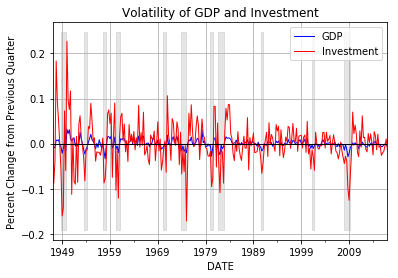

In [3]:
# some data are monthly - put everything into quartely by averaging over months
fred_data = fred_data.resample('Q').mean()
fred_data = fred_data[:-1] # drop last quarter since not all data available

# First-difference and detrend the data
# Note: probably a better way to do this
fred_data['dt_gdp']=fred_data['GDPC1'].pct_change(freq='Q') - np.mean(fred_data['GDPC1'].pct_change(freq='Q'))
fred_data['dt_inv']=fred_data['GPDIC96'].pct_change(freq='Q') - np.mean(fred_data['GPDIC96'].pct_change(freq='Q'))

# plot GDP and investment series
ax = fred_data.plot(y=['dt_gdp', 'dt_inv'], title="Volatility of GDP and Investment",
               grid=True, lw=1, color = ['blue', 'red'])
# Label y-axis
ax.set_ylabel("Percent Change from Previous Quarter")
# rename column vars for legend
ax.legend(['GDP', 'Investment'])
# add a zero line
ax.axhline(0, color='k', linestyle='-', linewidth=1)
# shade recessions
ax.fill_between(fred_data.index, ax.get_ylim()[0], ax.get_ylim()[1], where=fred_data['USREC'].values, color='gray', alpha=0.2)

This is pretty neat.  We can, with few line of code, gather and plot any data that FRED has.  `pandas-datareader` is doing a lot behind the scenes.  It is contacting the web address of the FRED servers which store these data, making a request to get these data, downloading those JSON files, and then creating the `fred_data` dataframe object from those JSON files. 

## Example 2:  Accessing Trade Data

Now we'll use an API for which there is not a Python wrapper.  In particular, we'll download trade data from the Observatory of Economic Complexity (OEC).  The OEC has compiled trade data from sources such as the United Nations Statistical Division (COMTRADE) and put them in one place.  These databases are large - trade flows by very dissaggregated levels of goods between all most country pairs from 1962-2015.

Fortunately, the OEC has an API we can use to access these data.  Details on how to use the API are [here](http://atlas.media.mit.edu/api/).  Let's use this and look at some trends in trade flows between the U.S. and China.

In [4]:
import requests
import json

# Format for URL: / CLASSIFICATION / TRADE_FLOW / YEAR / ORIGIN / DESTINATION / PRODUCT /
url = "http://atlas.media.mit.edu/sitc/export/1962.2015/chn/usa/all/"
response = requests.get(url)
trade_data = response.text
trade_data

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [5]:
df = pd.read_json(trade_data, orient='split')

In [6]:
df.describe()

,export_val,export_val_growth_pct,export_val_growth_pct_5,export_val_growth_val,export_val_growth_val_5,import_val,import_val_growth_pct,import_val_growth_pct_5,import_val_growth_val,import_val_growth_val_5,sitc_id,sitc_id_len,year
count,2.640900e+04,19960.000000,17162.000000,2.274700e+04,1.982800e+04,2.667100e+04,2.064800e+04,1.768300e+04,2.286100e+04,1.993900e+04,26740.000000,26740.0,26740.000000
mean,1.755299e+08,5.138533,0.403667,1.637223e+07,8.918930e+07,5.278059e+07,1.230195e+02,4.265944e+02,3.802195e+06,2.312802e+07,416858.844577,6.0,1997.168138
std,1.021788e+09,146.380937,3.531233,1.600377e+08,5.392408e+08,3.931690e+08,1.181163e+04,5.666209e+04,8.259172e+07,2.225723e+08,265011.797504,0.0,11.004220
min,0.000000e+00,-1.000000,-1.000000,-5.529963e+09,-5.497337e+09,0.000000e+00,-1.000000e+00,-1.000000e+00,-3.895364e+09,-1.548365e+09,105722.000000,6.0,1962.000000
25%,8.082900e+04,-0.111515,0.049065,-1.786300e+04,1.401550e+04,7.458450e+04,-2.721480e-01,-3.137670e-02,-1.162180e+05,0.000000e+00,127924.000000,6.0,1989.000000
50%,2.497000e+06,0.161091,0.211556,9.045600e+04,1.813711e+06,1.318726e+06,1.144840e-01,1.627230e-01,1.335400e+04,4.195130e+05,430712.000000,6.0,1998.000000
75%,4.085238e+07,0.638823,0.454965,3.731809e+06,2.598628e+07,1.284663e+07,7.696618e-01,4.059090e-01,1.244418e+06,6.386857e+06,618434.000000,6.0,2006.000000
max,3.855838e+10,13259.000000,248.825000,8.517509e+09,1.988833e+10,1.649505e+10,1.665890e+06,7.534780e+06,3.689362e+09,1.146957e+10,909610.000000,6.0,2015.000000


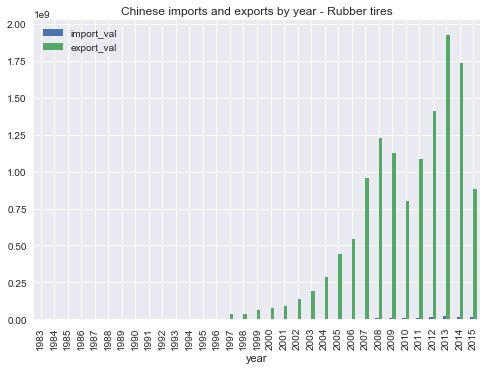

In [7]:
# plot data
plt.style.use('seaborn')
# use data just for one SITC category - Rubber tires, SITC code 106251
df[df['sitc_id']==106251].plot(x='year', y=['import_val','export_val'], kind='bar',
                              title='Chinese imports and exports by year - Rubber tires')

## Example 3: Twitter data

### Setting up

To use the Twitter API, you will need to have some credentials to authenticate yourself.  You can set these up by going to [https://apps.twitter.com](https://apps.twitter.com) and creating a new app.  This will allow you to get the credentials you need: `Consumer Key` and `Consumer Secret`. Depending on what you are doing, you might also need the `Access Token Key` and the `Access Token Secret`.  Grab all of these and store them in a file THAT YOU DO NOT SHARE (these are private).  I put these in a JSON file called `credentials.json`.  It contains the follwing (with my credentials removed):

```
{
  "consumer_key" : "...",
  "consumer_secret" : "...",
  "access_token_key" : "...",
  "access_token_secret" : "..."
}

```

The Twitter API has some notable limitations.  For example, the twitter API limits your search results to 100 tweets (in many circumstances, some times you can get more, but still not many thousands).  You can get more tweets by opening up a streaming API to gather tweets in realtime.  This can be done with they `TwythonStreaming` module - or with other packages that interface with the Twitter API.  

Note there are also Twitter APIs for enterprise use that allow you to gather more data, but they cost $$.

### Searching for tweets with a specific query

First, let's see how to grab tweets with a query.  E.g., we can try to grab tweets with a certain phrase in them.  There are seveal Python packages that provide wrappers or the Twitter API.  We'll use [Twython](https://twython.readthedocs.io/en/latest/).  [Tweepy](https://github.com/tweepy/tweepy) seems to also be popular.  But they all have similar structure, so once you get the handle on one, you can probably use others without much of a learning curve.

In [8]:
# import packages
from twython import Twython
from twython.exceptions import TwythonError
import json

# import credentials to connect to Twitter API
with open('credentials.json') as f:
    creds = json.loads(f.read())

# Initiate the client
client = Twython(
    creds['consumer_key'],
    creds['consumer_secret'],
    creds['access_token_key'],
    creds['access_token_secret']
)

In [9]:
# specify the search terms - and filter out retweets
query = '#MAGA -filter:retweets'

# use the client to run a search
geocode = '25.032341,55.385557,100mi' # latitude,longitude,distance(mi/km)

# results = client.search(q=query, count=100)
results = client.search(q=query, count=100, geocode=geocode)

In [10]:
# Look at how the results are structured
results.keys()
results['search_metadata']

{'completed_in': 0.094,
 'count': 100,
 'max_id': 923463003424641024,
 'max_id_str': '923463003424641024',
 'query': '%23MAGA+-filter%3Aretweets',
 'refresh_url': '?since_id=923463003424641024&q=%23MAGA%20-filter%3Aretweets&geocode=25.032341%2C55.385557%2C100mi&include_entities=1',
 'since_id': 0,
 'since_id_str': '0'}

In [11]:
len(results['statuses'])

10

In [12]:
# take a loot at data from a single tweet
results['statuses'][0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu Oct 26 08:15:11 +0000 2017',
 'entities': {'hashtags': [{'indices': [33, 38], 'text': 'MAGA'}],
  'symbols': [],
  'urls': [],
  'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 923463003424641024,
 'id_str': '923463003424641024',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'place': {'attributes': {},
  'bounding_box': {'coordinates': [[[54.8939725, 24.6182526],
     [56.2083722, 24.6182526],
     [56.2083722, 25.3686719],
     [54.8939725, 25.3686719]]],
   'type': 'Polygon'},
  'contained_within': [],
  'country': 'United Arab Emirates',
  'country_code': 'AE',
  'full_name': 'Dubai, United Arab Emirates',
  'id': '001907e868d06e24',
  'name': 'Dubai',
  '

In [13]:
# put results in a DataFrame
df = pd.DataFrame(results['statuses'])
df

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,possibly_sensitive,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,source,text,truncated,user
0,None,None,Thu Oct 26 08:15:11 +0000 2017,"{'hashtags': [{'text': 'MAGA', 'indices': [33,...",NaN,0,False,None,923463003424641024,923463003424641024,...,NaN,NaN,NaN,NaN,1,False,"<a href=""http://twitter.com/download/iphone"" r...",This is a good one - technically #MAGA should ...,False,"{'id': 704924209, 'id_str': '704924209', 'name..."
1,None,None,Wed Oct 25 16:12:16 +0000 2017,"{'hashtags': [{'text': 'MAGA', 'indices': [72,...",NaN,4,False,None,923220674696695809,923220674696695809,...,NaN,NaN,NaN,NaN,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@MuslimIQ You have to be kidding right??? That...,False,"{'id': 314212856, 'id_str': '314212856', 'name..."
2,None,None,Wed Oct 25 13:09:31 +0000 2017,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,1,False,None,923174683758944256,923174683758944256,...,False,{'created_at': 'Wed Oct 25 10:12:54 +0000 2017...,9.231302e+17,923130240309841920,1,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Would love to see the methodology used to dete...,True,"{'id': 2241022387, 'id_str': '2241022387', 'na..."
3,None,None,Mon Oct 23 17:23:07 +0000 2017,"{'hashtags': [{'text': 'maga', 'indices': [111...",NaN,0,False,None,922513730692317185,922513730692317185,...,False,NaN,NaN,NaN,0,False,"<a href=""http://paper.li"" rel=""nofollow"">Paper...",The latest The mass spectrometry Daily! https:...,False,"{'id': 742424959461556224, 'id_str': '74242495..."
4,None,None,Mon Oct 23 05:01:55 +0000 2017,"{'hashtags': [{'text': 'MAGA', 'indices': [92,...",NaN,0,False,None,922327201172934657,922327201172934657,...,False,{'created_at': 'Sun Oct 22 18:47:02 +0000 2017...,9.221725e+17,922172459973046272,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@realDonaldTrump @DonaldJTrumpJr @FLOTUS @Ivan...,False,"{'id': 425311644, 'id_str': '425311644', 'name..."
5,None,None,Wed Oct 18 23:35:20 +0000 2017,"{'hashtags': [{'text': 'MAGA', 'indices': [90,...","{'media': [{'id': 920794349306302464, 'id_str'...",0,False,None,920795460700463104,920795460700463104,...,False,NaN,NaN,NaN,0,False,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",".DanaPerino &amp; BradThor,\nThank you so much...",False,"{'id': 2777329473, 'id_str': '2777329473', 'na..."
6,None,None,Wed Oct 18 23:35:08 +0000 2017,"{'hashtags': [{'text': 'MAGA', 'indices': [90,...","{'media': [{'id': 920794349306302464, 'id_str'...",0,False,None,920795412994445312,920795412994445312,...,False,NaN,NaN,NaN,0,False,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",".DanaPerino &amp; BradThor,\nThank you so much...",False,"{'id': 756462537642741761, 'id_str': '75646253..."
7,None,None,Wed Oct 18 22:51:06 +0000 2017,"{'hashtags': [{'text': 'Dow23K', 'indices': [8...","{'media': [{'id': 920783752879661057, 'id_str'...",0,False,None,920784332679208960,920784332679208960,...,False,NaN,NaN,NaN,0,False,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...","""20,000📈21,000📈22,000📈 23,000📈this year...FOUR...",False,"{'id': 756462537642741761, 'id_str': '75646253..."
8,None,None,Wed Oct 18 22:51:02 +0000 2017,"{'hashtags': [{'text': 'Dow23K', 'indices': [8...","{'media': [{'id': 920783752879661057, 'id_str'...",1,False,None,920784312626270209,920784312626270209,...,False,NaN,NaN,NaN,0,False,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...","""20,000📈21,000📈22,000📈 23,000📈this year...FOUR...",False,"{'id': 2777329473, 'id_str': '2777329473', 'na..."
9,None,None,Wed Oct 18 17:03:09 +0000 2017,"{'hashtags': [{'text': 'MAGA', 'indices': [89,...",NaN,0,False,None,920696765619294208,920696765619294208,...,NaN,NaN,NaN,NaN,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@NBCNews How do African Americans that voted f...,False,"{'id': 74999448, 'id_str': '74999448', 'name':..."


### Searching for tweets from a specific user

Another option we have with Twython is to search for results from a specific user.  Here we need to provide a screen name or user id.  We can return up to about the 200 most recent tweets from the user.

In [14]:
tweets = []
tweet_loc = []
try:
    user_timeline = client.get_user_timeline(screen_name='realdonaldtrump',count=200)
except TwythonError as e:
    print(e)
print(len(user_timeline))
for tweet in user_timeline:
    # Add whatever you want from the tweet, here we just add the text
    tweets.append(tweet['text'])
    tweet_loc.append(tweet['geo'])
# Count could be less than 200, see:
# https://dev.twitter.com/discussions/7513
while len(user_timeline) != 0: 
    try:
        user_timeline = client.get_user_timeline(screen_name='realdonaltrump',
                                                 count=500,max_id=user_timeline[len(user_timeline)-1]['id']-1)
    except TwythonError as e:
        print(e)
    print(len(user_timeline))
    for tweet in user_timeline:
        # Add whatever you want from the tweet, here we just add the text
        tweets.append(tweet['text'])
        tweet_loc.append(tweet['geo'])
# Number of tweets the user has made
print(len(tweets))

200
5
0
205


In [15]:
# Looking at what is in the tweets we've compiled
tweets[0]

'Big news - Budget just passed!'

In [16]:
# Each tweet has much more infor than just the text we saved
tweet.keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

In [17]:
tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Sep 08 10:27:03 +0000 2014',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'nyti.ms/1wdBn1M',
    'expanded_url': 'http://nyti.ms/1wdBn1M',
    'indices': [96, 118],
    'url': 'http://t.co/MH4c2UHWwP'}],
  'user_mentions': [{'id': 807095,
    'id_str': '807095',
    'indices': [3, 11],
    'name': 'The New York Times',
    'screen_name': 'nytimes'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 508924469818437632,
 'id_str': '508924469818437632',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'possibly_sensitive': False,
 'retweet_count': 475,
 'retweeted': False,
 'retweeted_status': {'contributors': None,
  'coordinates': None,
  'created_at': 'Mon Sep 08 02:05:50 +0000 2014',
  'entities': {'hash

In [18]:
# Put the tweets in a dataframe
trump_df = pd.DataFrame(tweets)
trump_df

,0
0,Big news - Budget just passed!
1,Do not underestimate the UNITY within the Repu...
2,Ed Gillespie will be a great Governor of Virgi...
3,Ed Gillespie will turn the really bad Virginia...
4,RT @seanhannity: BOOM!! Tick Tock https://t.c...
5,Will be another Sean success! https://t.co/SlN...
6,RT @PChowka: Fox News With Hannity's Help Rega...
7,"Together, we will Make America Great Again!\n#..."
8,This will be the biggest TAX CUT in the histor...
9,RT @IvankaTrump: Working families need #TaxRef...


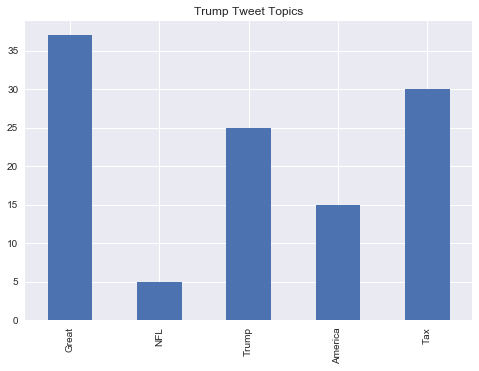

In [24]:
# Plot the frequency of certain text
trump_df['Great'] = trump_df[0].str.contains('Great', case=False)
trump_df['Trump'] = trump_df[0].str.contains('Trump')
trump_df['America'] = trump_df[0].str.contains('America')
trump_df['Tax'] = trump_df[0].str.contains('Tax', case=False)
trump_df['NFL'] = trump_df[0].str.contains('NFL')
trump_df[["Great", "NFL", "Trump", "America", "Tax"]].sum().plot(kind = "bar", title='Trump Tweet Topics')

In [23]:
'Great' + 'Trump'

'GreatTrump'